# Produce some plots of importation probabilities

Use the analytical formulas from Wallinga and Scalia Tomba


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from tqdm import tqdm
import numpy.linalg as nla

## Jacob

In [2]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew
    
    

In [3]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    def __init__(self, offspring):
        self.offspring = offspring
    def set_lifespans(self, omega):
        self.omega = omega
    def set_immigration(self, eta):
        
        self.eta = eta
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
        method = methodclass(set_odes)
        method.set_ic(u0=ics)
        R, t = method.solver(time_points=t)
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if isinstance(n0, float):
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if isinstance(u, float):
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = Omega(t)@u + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
        method = methodclass(set_mean_odes)
        method.set_ic(u0=ics)
        M, t = method.solver(time_points=t)
        return M
        

# Variants Paper

In [25]:
# Parameters to change 

ntypes = 16
nexposed = int(ntypes/2)

# Disease Parameters

Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype with roadmap changes
rtrans_variant = 1.5 # Relative transmissability of SA variant compared to wildtype
gamma = 0.4 # Recovery Rate
sigma = 0.3 # Progression rate from exposed to infectious

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
az_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to AstraZeneca vaccine
pfi_vac_uk = 1-0.7 # Reduction in transmission of UK variant due to Pfizer vaccine
new_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to new vaccine
az_vac_sa = 1-0.1 # Reduction in transmission of SA variant due to AstraZeneca vaccine
pfi_vac_sa = 1-0.5 # Reduction in transmission of SA variant due to Pfizer vaccine
new_vac_sa = 1-0.9 # Reduction in transmission of SA variant due to new vaccine
vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

k = 1/10 # Dispersion Endo et al.

Tmax = 30
time = np.linspace(0, Tmax, num=1000)

# Reduced transmissability for each type based on infection/vaccine immunity
const_vec = np.array((1., sus_sa, az_vac_sa, az_vac_sa*sus_sa, pfi_vac_sa, pfi_vac_sa*sus_sa, new_vac_sa, new_vac_sa*sus_sa))

# Variable beta
# beta_vec = np.array((1., ))

# Vector of proportions of susceptibles for each type:


p_az = 0.32
p_pf = 0.17
p_new = 0
p_no_vac = 1- p_az - p_pf - p_new

p_rec = 0.245
p_sus = 1-p_rec


prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_az, p_rec*p_az, p_sus*p_pf, p_rec*p_pf, p_sus*p_new, p_rec*p_new))



# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days
im_vec = np.zeros(ntypes)
im_vec[0] = 1/5





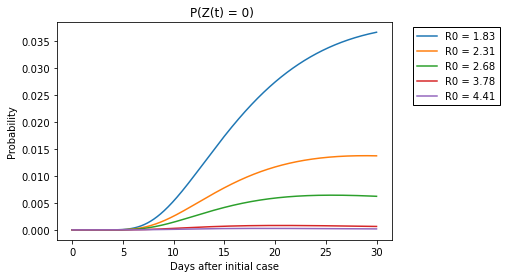

In [26]:
# Solve ODEs 

rho_mat = np.zeros((len(Reff_vec), len(time)))
q_mat = np.zeros_like(rho_mat)
R_vec = np.zeros_like(Reff_vec)
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant

    # Probability of extinction with immigration

#     omega_infectious = beta_SA*np.ones(nexposed)
#     omega_infectious[1::2] *= sus_sa
#     for i in range(0, len(vaccine_vec)):
#         omega_infectious[2*i:2*i+2]*= vaccine_vec[i]
#     omega_infectious += gamma
#     om_vec = np.append(sigma*np.ones(nexposed), omega_infectious)
    
    omega_vec = sigma * np.ones(ntypes)              
    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
    def omega(t): # Return vector of lifetimes for each state
        return omega_vec

    beta_vec = beta_SA*np.ones(nexposed)
    for i in range(0, len(vaccine_vec)):
        beta_vec[2*i:2*i+2]*= vaccine_vec[i]
    
    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_SA) + gamma)
        sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*(1+(1/k)*(1-u[:nexposed]))**(-k))


        for nex in range(0, nexposed):
            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs + (gamma/omega)
        return pvec            
            
            
    def eta(t):
        return im_vec.astype(float)
    ics = np.zeros(ntypes+1)
    ics[-1] = 1.
    n0vec = np.ones(ntypes)
    n0vec[-1] = 0


    offspring = P
    outbreak = MTBP_extinct(offspring)
    outbreak.set_lifespans(omega)
    outbreak.set_immigration(eta)
    rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = False)
    q_mat [r, :] = rho[0, :]
    rho_mat[r, :] = rho[1, :] # Take 0th row for qs, -1th row for rs

    plt.plot(time, rho_mat[r, :], label = "R0 = " + str(np.round(RV, 2)))

plt.title("P(Z(t) = 0) " )
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
plt.savefig("./pnocases_R0=" + str(RV) + ".pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)

In [27]:
# Ignore for now - this is to build next generation matrix
# def R_eff(): 
#         Sig = np.zeros((ntypes, ntypes))
#         for i in range(0, nexposed):
#             Sig[i, i] -= sigma
#             Sig[i, i+nexposed] += sigma
#             Sig[i +nexposed, i+nexposed] -= gamma
#         SigInv = nla.inv(Sig)
        
#         T = np.zeros((ntypes, ntypes))
#         for i in range(0, nexposed):
#             T[i, i+nexposed] += beta_SA
        
#         Rmat_eig = np.max(nla.eig(-T@SigInv)[0])
#         return Rmat_eig
# R_eff()

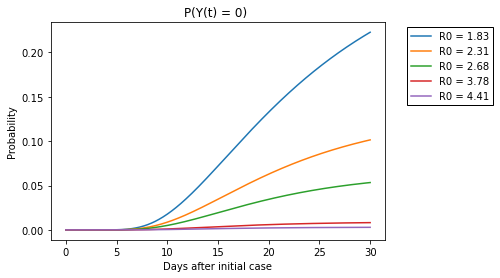

In [28]:
# Equivalent probabilities for a single lineage - no immigration

for r, Reff in enumerate(Reff_vec):
    RV = Reff*rtrans_variant
    plt.plot(time, q_mat[r, :], label = "R0 = " + str(np.round(RV, 2)))

plt.title("P(Y(t) = 0) ") # Y(t) is process for an individual lineage to go extinct without immigration
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
plt.savefig("./pnocases_R0=" + str(RV) + ".pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)

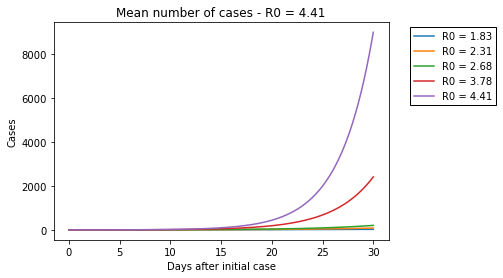

In [29]:
# Mean over time 
mean_cond = np.zeros((len(Reff_vec), len(time)))
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    
    def Omega(t): # Matrix of first partial derivatives of offspring distribution.
        nexposed = len(const_vec)
        Omat = np.zeros((ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)       
        
        for nex in range(0, nexposed):
            omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
            Omat[nex, nex+nexposed] = omega_vec[nex]
            Omat[nex+nexposed, :nexposed] = const_vec[nex]*prop_vec[nex]*beta_SA 
            Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

        Omat -= np.diag(omega_vec)
        
        return Omat
    outbreak.set_Omega(Omega)
    n0s = np.zeros(ntypes)
    Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)
    mean_cond[r, :] = np.sum(Mvec/(1-rho_mat[r, :]), axis=0)
    plt.plot(time, mean_cond[r, :], label = 'R0 = ' + str(np.round(RV, 2)))
plt.title("Mean number of cases - R0 = " + str(np.round(RV, 2)))
plt.xlabel("Days after initial case")
plt.ylabel("Cases")
plt.savefig("./meancases_R0=" + str(np.round(RV, 2)) + ".pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)


In [9]:
# Variance  - for highest R0 (or single value to be chosen)

beta_SA = Reff_vec[-1]*gamma*rtrans_variant

def Omega(t): # Repeat matrix of partial derivatives for just one R0 
    nexposed = len(const_vec)
    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)

    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
        Omat[nex, nex+nexposed] = omega_vec[nex]
        Omat[nex+nexposed, :nexposed] = const_vec[nex]*prop_vec[nex]*beta_SA 
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

    Omat -= np.diag(omega_vec)

    return Omat

# Diagonalise Omega and find H as in Garden of BPs paper

eigvls, orth = nla.eig(Omega(0))
diagmat = np.diag(eigvls)
H = np.kron(orth, np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate())))
Hinv = np.kron(nla.inv(orth), np.kron(orth.conjugate(), orth.conjugate()))
Hinv = nla.inv(H)

In [10]:
def H_mat(t): # Hessian of the Offspring Distribution 

    Hmat = np.zeros((ntypes, ntypes, ntypes))
    
    for level in range(0, nexposed):

        for i in range(0, nexposed):
            
            Hmat[level + nexposed, i, i] = (1 + (k+1)/k) * (const_vec[i]*beta_SA*prop_vec[i])/(omega_vec[level+nexposed])
            Hmat[level + nexposed, level+nexposed, i] = (beta_SA * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
            Hmat[level + nexposed, i, level+nexposed] = (beta_SA * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
    
    return Hmat

def P_vecs(t): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        Omat[nex + nexposed, nex] = 1
        Omat[nex+nexposed, :nexposed] =  (const_vec[nex]*beta_SA*prop_vec[nex])/omega_vec[nex+nexposed] 
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA*prop_vec)/omega_vec[nex+nexposed] 
    
#     return np.transpose(Omat)
    return Omat


In [11]:
# Build a vector C from matrix G as in Garden of BPs 
Gmat = np.zeros((ntypes, ntypes, ntypes))
C = np.zeros(ntypes**3)
for l in range(0, ntypes):
    Gmat[l, :, :] = H_mat(0)[l, :, :] + np.diag(P_vecs(0)[:, l]) - np.outer(P_vecs(0)[:, l], P_vecs(0)[:, l])
    unitvec = np.zeros(ntypes)
    unitvec[l] = 1
    Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(P_vecs(0)[:, l], P_vecs(0)[:, l]) - np.outer(unitvec, P_vecs(0)[:, l]) - np.outer(P_vecs(0)[:, l], unitvec)
    Gmat[l, :, :] *= omega_vec[l]
    C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator


In [12]:
def Deltamat(t, immigration):
    Delta = np.zeros(ntypes**2)
    eigs = eigvls.copy()
    for j in range(0, ntypes):
        for n in range(0, ntypes):
            Delta[j*ntypes + n] =  (1-np.exp((eigs[j] + eigs[n])*t))/(-eigs[j] - eigs[n])
    Deltamat = np.diag(Delta)
    return Deltamat


def Deltamat_im(t, immigration):
    Delta = np.zeros(ntypes**3)
    eigs = eigvls.copy()
    for l in range(0, ntypes):
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[l*ntypes*ntypes + j*ntypes + n] = (1/(eigs[l] - (eigs[j] + eigs[n])))*((np.exp(eigs[l]*t) - 1)/(eigs[l]) - (np.exp((eigs[j] + eigs[n])*t) - 1)/(eigs[j] + eigs[n]))
                
    Deltamat = np.diag(Delta)
    return Deltamat

In [13]:
def var(t):
    # Build both components for variance with immigration from eq. 21 and final eq. on p.213
    
    Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
    vec_w = np.zeros(ntypes**3)
    for i in range(0, ntypes):
        unitvec = np.zeros(ntypes)
        unitvec[i] = 1.
        unit_outer_prod = np.outer(unitvec, unitvec).flatten('F') # Stack columns for 'vec' operator
        vec_wi =  Amat @ Deltamat(t, im_vec) @ nla.inv(Amat)@unit_outer_prod
        vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
    
    Amat = np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate()))
    vecvar =  H @ Deltamat_im(t, im_vec) @ Hinv @ C + vec_w
#     var = np.zeros((ntypes, ntypes, ntypes))
    var = np.reshape(vecvar, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
    for i in range(0, ntypes):
        var[i]*=im_vec[i]
#     for l in range(0, ntypes): # This was a source of errors
#         for j in range(0, ntypes):
#             for n in range(0, ntypes):
#                 var[l, j, n] = vecvar[l*ntypes*ntypes + j*ntypes + i]
    
    return var

In [21]:
varmat = np.sum(var(50), axis=0) # Sum variance for all different types into total variance matrix

In [22]:
lamb = np.max(eigvls)
lamb # This is growth rate 

0.3011449970628659

In [23]:
np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate())).shape

(256, 256)

In [24]:
vars = np.zeros(ntypes)
for i in range(0, ntypes):
    vars[i] = varmat[]

array([1.38825220e+06, 1.42643007e+06, 2.42727178e+06, 1.86867016e+03,
       2.74594441e+06, 3.60244502e+05, 4.77133103e+02, 5.08940486e+02,
       1.53372397e+05, 1.55702311e+04, 6.74999300e+02, 6.62157930e+02,
       4.18097103e+02, 3.30049715e+02, 3.04969564e+02, 3.04969564e+02])

In [18]:
Mvec[:, -1]

array([ 598390.98672411,  116507.78417016,  337914.53367961,
         65792.6310608 ,   99731.72000961,   19417.96402836,
             0.        ,       0.        , 1199064.94294572,
        233460.32663976,  677119.02660464,  131836.41974951,
        199844.15715762,   38910.05443996,       0.        ,
             0.        ])

In [19]:
tstars = np.zeros(len(Reff_vec))
astar = 100
for r, Reff in enumerate(Reff_vec):
    if mean_cond[r, -1]>=astar:
        tstar = time[np.min(np.where(mean_cond[r, :] >= astar)[0])]
    else:
        tstar = np.nan
    tstars[r] = tstar
tstars

array([47.04704705, 31.33133133, 25.52552553, 17.46746747, 15.11511512])